In [3]:
import ax
import os
from typing import Any, Mapping
import subprocess
import logging

import numpy as np 
from ax.api.client import Client
from ax.api.configs import RangeParameterConfig
from ax.api.protocols.metric import IMetric
from ax.api.protocols.runner import IRunner, TrialStatus
from ax.api.types import TParameterization 
import json
from ax import Client, RangeParameterConfig, ChoiceParameterConfig
import helperfunctions
from ax.api.protocols.metric import IMetric
from ax.api.protocols.runner import IRunner, TrialStatus



In [4]:
import os
print(os.getcwd())
import sys
print(sys.path)

c:\Users\arses\Desktop\BayesianOptimization
['C:\\Users\\arses\\AppData\\Local\\Programs\\Python\\Python313\\python313.zip', 'C:\\Users\\arses\\AppData\\Local\\Programs\\Python\\Python313\\DLLs', 'C:\\Users\\arses\\AppData\\Local\\Programs\\Python\\Python313\\Lib', 'C:\\Users\\arses\\AppData\\Local\\Programs\\Python\\Python313', 'c:\\Users\\arses\\Desktop\\BayesianOptimization\\newenv', '', 'c:\\Users\\arses\\Desktop\\BayesianOptimization\\newenv\\Lib\\site-packages', 'c:\\Users\\arses\\Desktop\\BayesianOptimization\\newenv\\Lib\\site-packages\\win32', 'c:\\Users\\arses\\Desktop\\BayesianOptimization\\newenv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\arses\\Desktop\\BayesianOptimization\\newenv\\Lib\\site-packages\\Pythonwin']


<font size = 5> Logger for error handling

In [5]:
logger = logging.getLogger('Optimization_logger')
logger.setLevel(logging.DEBUG)
formatter= logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

#Creatinfaa handler to send messages to the console 
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO) #min level of the messages to be sent 
console_handler.setFormatter(formatter)

#Creatinf  handler to set message to a file 
file_handler = logging.FileHandler('file_name')
file_handler.setLevel(logging.DEBUG) #min level of the messages to be sent
file_handler.setFormatter(formatter)

#add handlers to the logger
logger.addHandler(console_handler)
logger.addHandler(file_handler)

<FONT SIZE = 6> Interaction (Deploying and Fetching) with an external system 

In [6]:
INPUT_DIR = "C://AJP/input_parameters"
OUTPUT_DIR = "C://AJP/output_parameters"
POWER_AUTOMATE_FLOW_ID = "AUTOMATE_FLOW_ID"



class Runner(IRunner):

    #run_trial deploys a trial to the external system with the given parameters. 
    #Saves a JSON file of the input and deploys the Windows Power Automation 
    #Returns the updated input and output file path, and the index of the experiment. 

    def run_trial(
        self, trial_index: int, parameterization: TParameterization ) -> dict[str, Any]:
        
        #create directories for input nd output values 
        os.makedirs(INPUT_DIR, exist_ok= True)
        os.makedirs(OUTPUT_DIR, exist_ok = True)

        input_file_path = os.path.join(INPUT_DIR, f"params_{trial_index}.json")
        with open(input_file_path, "w") as f: 
            json.dump(parameterization, f, indent=4)

        output_file_path = os.path.join(OUTPUT_DIR, f"results_{trial_index}.json")
       
        command = [
            "C:\\Program Files (x86)\\Power Automate Desktop\\PAD.Console.Host.exe", # Default path, verify on your system
            "run",
            "--flowId", POWER_AUTOMATE_FLOW_ID,
            "--input", f"InputFilePath={input_file_path}"
        ]
        print(f"Launching Power Automate flow for trial{trial_index}...")


        process = subprocess.Popen(command, #commands to execute
                                   stdout=subprocess.PIPE, #standard output of the external command will be captured by a pipe
                                   stderr= subprocess.PIPE, #standard error output of the external command will be captured by the pipe
                                   text= True
            
        )

        print(f"Power Automate flow for trial {trial_index} launched with PID:{process.pid}")

        return_code = process.wait()

        if return_code !=0: 
            print(f"Power Automte flow for trial{trial_index} exited with non-zero code :{return_code}")
        else: 
            print(f"Power Automate flow for trial {trial_index} completed normally.")


        return {
            "trial_index": trial_index, 
            "input_file_path": input_file_path, 
            "output_file_path": output_file_path
        }
         
    #poll_trial queries the external system to see if the trial has completed, failed, or if it's still runing. There is room to explore how this can be
    # done or if this is needed at all. 
    
    def poll_trial(self, trial_index :int, trial_metadata: Mapping[str, Any]) -> TrialStatus: 

        output_file_path = trial_metadata["output_file_path"]
        if not os.path.exists(output_file_path): 
            print(f"Error: Output file not found for trial{trial_index} after P flow completed")
            return TrialStatus.FAILED
        
        try: 
            with open(output_file_path, "r") as f: 
                results_data = json.load(f)
        
            status_from_file = results_data.get("trial_status")

            if status_from_file =="COMPLETED": 
                return TrialStatus.COMPLETED
            elif status_from_file == "FAILED": 
                return TrialStatus.FAILED
            else: 
                #does not return a status in this case 
                print(f"Warning: Unexpectec status '{status_from_file}' in output file for trial {trial_index}.")

        except json.JSONDecodeError: 
            print (f"Error: Invalid JSON in {output_file_path} for trial {trial_index}.")
            logger.error(f"Invalid JSON in {output_file_path} for trial {trial_index}.")
            return TrialStatus.FAILED
        
        # general error handler, designed to handle any type of error that mihgt occus within the try block, that wasn't specifically caught
        # e is a variable that holds the exception object tht was raiseed       
        except Exception as e: 
            print(f"Error accessing output file for {trial_index}: {e}")
            return TrialStatus.FAILED

<Font size = 5> Extracting required information from the completed experiment

In [7]:
class Metric(IMetric): 
    def fetch(
        self, 
        trial_index: int, 
        trial_metadata: Mapping[str, Any], ) -> dict[str, float| Any]:

        output_file_path = trial_metadata["output_file_path"]
        if not os.path.exists(output_file_path): 
            print(f"Error: Output file not found for trial{trial_index} after flow completed")
            logger.error(f"Output file not found for trial no. {trial_index}")
            return {"line_width": None}

        try: 
            with open (output_file_path,  'r') as file: 
                results_data  = json.load(file)
            value =results_data.get("line_width")
            logger.info(f"Trial was successful for trian index : {trial_index}")
            return {"line_width":value}
            
            
        except json.JSONDecodeError:
            print(f"Error: File is not in Json format for index {trial_index}")
            return {"line_width": None}
        
        except Exception as e: 
            print(f"Error accesing the output value for {trial_index}: {e}")
            return {"line_width": None}


In [11]:
client = Client()

carrier_gas_flow = RangeParameterConfig(name="layer_height", parameter_type="float", bounds=(1, 10))
sheath_gas_flow = RangeParameterConfig(name="sheath_gas_flow", parameter_type="float", bounds = (50, 200))
number_of_loops = RangeParameterConfig(name = "number_of_loops", parameter_type ="int", bounds=(1,5) )
speed = RangeParameterConfig(name ="speed", parameter_type = "float", bounds = (50, 300))

parameters = [sheath_gas_flow, carrier_gas_flow, speed, number_of_loops]

client.configure_experiment(parameters=parameters, 
                            name = "AJP_Optimization")
client.configure_optimization(objective= "-line_width")

<font size =6> Optimization Loop

In [12]:
for _ in range(10): # Run 10 rounds of trials
    
    
    # We will request three trials at a time in this example
    trials = client.get_next_trials(max_trials= 3) 

    
    for trial_index, parameters in trials.items():
        x1 = parameters["x1"]
        x2 = parameters["x2"]
        x3 = parameters["x3"]
        x4 = parameters["x4"]
        x5 = parameters["x5"]
        x6 = parameters["x6"]


        #This is where the main experimentation part happens: Where I delegate the task to the outer system
        result = hartmann6(x1, x2, x3, x4, x5, x6)

        # Set raw_data as a dictionary with metric names as keys and results as values
        raw_data = {metric_name: result}


        
        # Complete the trial with the result 
        
        #[client.complete_trial(parameters, result]
        #This is kept Ax in the database to generate data for the nextstep        
        client.complete_trial(trial_index=trial_index, raw_data=raw_data)
        print(f"Completed trial {trial_index} with {raw_data=}")

KeyError: 'x1'

In [13]:
runner = Runner()
line_width_metric = Metric(name = "line_width")
client.configure_runner(runner=runner) 
client.configure_metrics(metrics=[line_width_metric]) 

client.run_trials(  
    max_trials = 30, 
    parallelism= 2, 
    tolerated_trial_failure_rate= 0.2
)




[INFO 07-16 14:34:37] Scheduler: `Scheduler` requires experiment to have immutable search space and optimization config. Setting property immutable_search_space_and_opt_config to `True` on experiment.


KeyError: 'output_file_path'

Line width (in pixels): 23.00
Line width (in pixels): 80.00
Line width (in pixels): 85.00
Line width (in pixels): 68.00
Line width (in pixels): 70.57


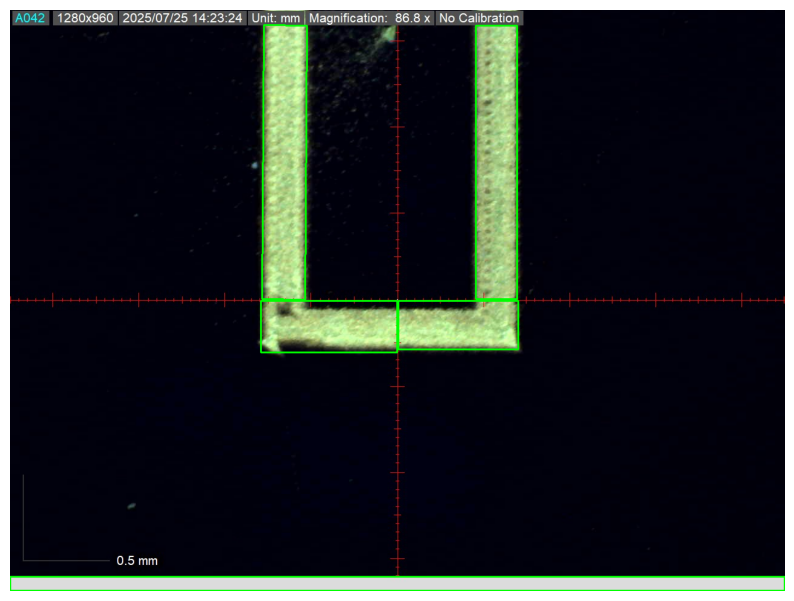

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image
img = cv2.imread(r"C:\Users\arses\Downloads\testpicture.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Thresholding to binary
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Optional: Morphological cleaning
kernel = np.ones((5,5), np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Find contours
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy to draw on
output = img.copy()

# Draw contours and bounding boxes
for cnt in contours:
    area = cv2.contourArea(cnt)

    
    if area > 1000:  # Filter out small noise
        rect = cv2.minAreaRect(cnt)  # Rotated rect
        box = cv2.boxPoints(rect)
        box = np.int32(box)

        # Draw bounding box
        cv2.drawContours(output, [box], 0, (0, 255, 0), 2)

        # Width and height of bounding box
        w, h = rect[1]
        width = min(w, h)  # Assuming horizontal line
        print(f"Line width (in pixels): {width:.2f}")

# Display result
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
